<a href="https://colab.research.google.com/github/conorlime/CS6271/blob/main/GE%20Applied%20to%20Classification%20(Single%20Type).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#**Artificial Intelligence - MSc**
##CS6271 - Evolutionary Agorithms and Humanoid Robotics 
###GE Applied to single type classification 


Leader: Conor Ryan

Developer: Allan de Lima

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone this repository in which we have all functions and classes created or adapted to this work.

In [2]:
import os.path

PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /content/drive/MyDrive/grape/

/content/drive/MyDrive
Cloning into 'grape'...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 183 (delta 105), reused 131 (delta 57), pack-reused 0
Receiving objects: 100% (183/183), 2.63 MiB | 5.82 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Cloning grape in your Drive
/content/drive/MyDrive/grape


Import our algorithms, adapted from deap.algorithms.


Import functions used by our grammars.



In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install deap==1.3 

import grape
import algorithms

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools

import random

from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Set our Grammatical Evolution parameters.

In [59]:
POPULATION_SIZE = 1000
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be smaller or equal to HALLOFFAME_SIZE
HALLOFFAME_SIZE = 1 #round(0.01*POPULATION_SIZE) #it should be at least 1

CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 5
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 
                'fitness_test',
                'best_ind_length', 'avg_length', 
                'best_ind_nodes', 'avg_nodes', 
                'avg_depth', 
                'avg_used_codons', 'best_ind_used_codons', 
                'selection_time', 'generation_time']
                

Set a random seed.

In [60]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

Set a problem to solve. This notebook is ready to run experiments for 'spambase' and 'Banknote'. And you could easily modify for other problems.

In [32]:
problem = 'Banknote'

Read datasets and grammars according to the problem picked in the previous cell.

In [61]:
if problem == 'Banknote':
    from functions import add, sub, mul, pdiv, neg, psqrt, plog
    X_train = np.zeros([1000, 4], dtype=float)
    Y_train = np.zeros([1000,], dtype=bool)
    X_test = np.zeros([372, 4], dtype=float)
    Y_test = np.zeros([372,], dtype=bool)

    data = pd.read_table(r"datasets/banknote_Train.csv", sep=" ")
    for i in range(1000):
        for j in range(4):
            X_train[i,j] = data['x'+ str(j)].iloc[i]
    for i in range(1000):
        Y_train[i] = data['y'].iloc[i] > 0
        
    data = pd.read_table(r"datasets/banknote_Test.csv", sep=" ")
    for i in range(372):
        for j in range(4):
            X_test[i,j] = data['x'+ str(j)].iloc[i]
    for i in range(372):
        Y_test[i] = data['y'].iloc[i] > 0
    
    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)
        
    GRAMMAR_FILE = 'Banknote.bnf'
    
elif problem == 'spambase':
    from functions import add, sub, mul, pdiv, neg
    X = np.zeros([4601, 57], dtype=float)
    Y = np.zeros([4601,], dtype=int)

    data = pd.read_table(r"datasets/spambase.csv")
    for i in range(4601):
        for j in range(57):
            X[i,j] = data['d'+ str(j)].iloc[i]
    for i in range(4601):
        Y[i] = data['class'].iloc[i]
        
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_SEED)
    
    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)
        
    GRAMMAR_FILE = 'spambase.bnf'

Print data.

In [34]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

data.head()

,x0,x1,x2,x3,y
0,-2.2183,-1.2540,2.99860,0.36378,1.0
1,-1.8046,-6.8141,6.70190,1.16810,1.0
2,-4.5770,3.4515,0.66719,-0.94742,1.0
3,2.7161,-4.2006,4.19140,0.16981,-1.0
4,3.8905,-2.1521,2.63020,1.10470,-1.0


Print grammar.

In [35]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close() 

<e> ::= (<e> <op> <e>) | <f1>(<e>) | <f2>(<e>, <e>) | <v> | <c>
<op> ::= + | * | -
<f1> ::= psqrt | plog
<f2> ::= pdiv
<v> ::= x[0] | x[1] | x[2] | x[3]
<c> ::= -1.0 | -0.1 | -0.01 | -0.001 | 0.001 | 0.01 | 0.1 | 1.0


Set up the grammar addressed by GRAMMAR_FILE in the class Grammar.

In [36]:
BNF_GRAMMAR = grape.Grammar(path.join("grammars", GRAMMAR_FILE))

Define as fitness function the number of outputs wrongly predicted.

In [12]:
def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]
    
    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FloatingPointError and OverflowError can happen for example, if you have lots of pow/exp calls
        # ZeroDivisionError can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)
    
    try:
        Y_class = [1 if pred[i] > 0 else 0 for i in range(len(Y))]
    except (IndexError, TypeError):
        return np.NaN,

    compare = np.equal(Y,Y_class)
    fitness = 1 - np.mean(compare)
   
    return fitness,

Create the deap toolbox.

Use negative weights in the `base.Fitness` since we are trying to minimise the fitness.

`grape.Individual` is a class with the following attributes: `phenotype`, `nodes`, `depth`, `used_codons`, `invalid` (True or False), `n_wraps` and `self.structure`.

`grape.sensible_initialisation` initialises a whole population of GE individuals using Sensible Initialisation.

`tools.selTournament` usef Tournament to select parents.

`grape.crossover_onepoint` selects crossover points within the used portion of the genome. 

Similarly, `grape.mutation_int_flip_per_codon` performs only over the effective length.



In [62]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", grape.sensible_initialisation, creator.Individual) 
#toolbox.register("populationCreator", grape.random_initialisation, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", tools.selTournament, tournsize=7)

# Single-point crossover:
toolbox.register("mate", grape.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", grape.mutation_int_flip_per_codon)


Set the main function and run it.

Set the statistics object regarding the fitness score, but there are other statistics defined internally.

Perform Grammatical Evolution using `algorithms.ge_eaSimpleWithElitism`, a simple evolutionary algorithm. The differences to the `algorithms.ge_eaSimpleWithElitism` used by deap are:

*   We use elitism (if you do not want to use, just set ELITISM_SIZE = 0);
*   After crossover and mutation, we check the offspring to assure that the max depth is not violated;
*   We measure many other things to report, such as the generation and the selection times, the number of invalid individuals etc.

In [63]:
# create initial population (generation 0):
population = toolbox.populationCreator(pop_size=POPULATION_SIZE, 
                                      bnf_grammar=BNF_GRAMMAR, 
                                      min_init_depth=MIN_INIT_TREE_DEPTH,
                                      max_init_depth=MAX_INIT_TREE_DEPTH,
                                      codon_size=CODON_SIZE,
                                      codon_consumption=CODON_CONSUMPTION,
                                      genome_representation=GENOME_REPRESENTATION
                                      )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALLOFFAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                              bnf_grammar=BNF_GRAMMAR, 
                                              codon_size=CODON_SIZE, 
                                              max_tree_depth=MAX_TREE_DEPTH,
                                              max_genome_length=MAX_GENOME_LENGTH,
                                              points_train=[X_train, Y_train], 
                                              points_test=[X_test, Y_test], 
                                              codon_consumption=CODON_CONSUMPTION,
                                              report_items=REPORT_ITEMS,
                                              genome_representation=GENOME_REPRESENTATION,                                              
                                              stats=stats, halloffame=hof, verbose=False)

gen = 0 , Best fitness = (0.15100000000000002,) , Number of invalids = 0
gen = 1 , Best fitness = (0.15100000000000002,) , Number of invalids = 245
gen = 2 , Best fitness = (0.14800000000000002,) , Number of invalids = 311
gen = 3 , Best fitness = (0.14800000000000002,) , Number of invalids = 320
gen = 4 , Best fitness = (0.14500000000000002,) , Number of invalids = 317
gen = 5 , Best fitness = (0.14500000000000002,) , Number of invalids = 335
gen = 6 , Best fitness = (0.14500000000000002,) , Number of invalids = 328
gen = 7 , Best fitness = (0.122,) , Number of invalids = 344
gen = 8 , Best fitness = (0.122,) , Number of invalids = 350
gen = 9 , Best fitness = (0.122,) , Number of invalids = 354
gen = 10 , Best fitness = (0.122,) , Number of invalids = 378
gen = 11 , Best fitness = (0.122,) , Number of invalids = 372
gen = 12 , Best fitness = (0.122,) , Number of invalids = 377
gen = 13 , Best fitness = (0.11399999999999999,) , Number of invalids = 371
gen = 14 , Best fitness = (0.113

Show the best individual.

In [64]:
import textwrap
best = hof.items[0].phenotype
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])

print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 pdiv(pdiv((1.0 + -0.1), -0.001), (pdiv(x[0], ((-1.0 * (psqrt(0.01) -
psqrt(x[1]))) - plog(pdiv(x[1], 1.0)))) - x[3]))

Training Fitness:  0.11399999999999999
Depth:  10
Length of the genome:  99
Used portion of the genome: 0.40


Extract statistics and build a nice table.

In [65]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")

best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")

selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")
avg_used_codons = logbook.select("avg_used_codons")
best_ind_used_codons = logbook.select("best_ind_used_codons")

best_ind_nodes = logbook.select("best_ind_nodes")
avg_nodes = logbook.select("avg_nodes")

avg_depth = logbook.select("avg_depth")

header = REPORT_ITEMS

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, 
                                min_fitness_values, max_fitness_values, fitness_test, 
                                best_ind_length, avg_length,  
                                best_ind_nodes, avg_nodes, 
                                avg_depth, 
                                avg_used_codons, best_ind_used_codons, 
                                selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,best_ind_nodes,avg_nodes,avg_depth,avg_used_codons,best_ind_used_codons,selection_time,generation_time
0,0,0,0.554508,0.106130,0.151,0.850,NaN,13,148.257344,5,54.823737,8.050529,98.970623,9,0.000000,0.878208
1,1,245,0.515364,0.131797,0.151,0.850,NaN,13,193.031898,5,46.400319,8.704944,83.816587,9,0.010844,1.342991
2,2,311,0.509373,0.145303,0.148,0.851,NaN,116,194.448155,32,38.745167,8.952548,70.033392,58,0.010268,1.129429
3,3,320,0.496656,0.144847,0.148,0.861,NaN,116,191.882998,32,33.879342,9.237660,61.164534,58,0.010896,1.037464
4,4,317,0.487659,0.142744,0.145,0.855,NaN,80,187.335753,20,30.787659,9.257713,55.553539,39,0.011608,0.994865
5,5,335,0.480648,0.149249,0.145,0.849,NaN,80,181.308257,20,31.297248,9.664220,56.425688,39,0.011210,1.080939
6,6,328,0.472671,0.162530,0.145,0.849,NaN,80,166.417857,20,28.226786,9.682143,50.883929,39,0.010957,0.976548
7,7,344,0.453292,0.182397,0.122,0.862,NaN,230,160.567468,55,25.354898,9.569316,45.658041,99,0.011089,0.898668
8,8,350,0.446106,0.185000,0.122,0.862,NaN,230,150.581749,55,24.108365,9.452471,43.414449,99,0.011667,0.877326
9,9,354,0.407010,0.196120,0.122,0.849,NaN,230,152.036072,55,23.825651,9.537074,42.869739,99,0.010910,0.869845


Plot graph regarding the best individual in each generations considering the training set.

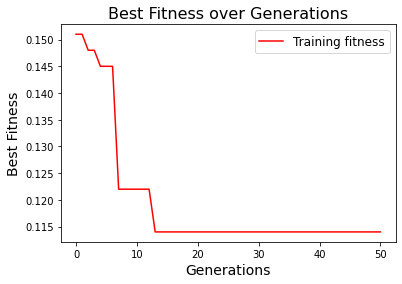

In [66]:
plt.plot(gen, min_fitness_values, color='red', label="Training fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.show()


Show the score in the test set.

In [67]:
print("\nTest Fitness: ", fitness_test[-1])


Test Fitness:  0.10752688172043012


Plot graph regarding the average fitness in each generation considering the training set.

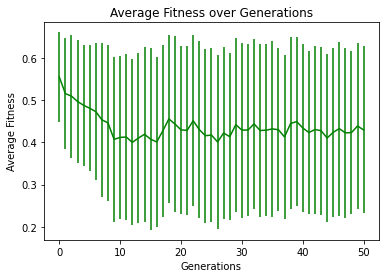

In [68]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

Plot graphs regarding the length of the genome: the average of the population and that one of the best individual.


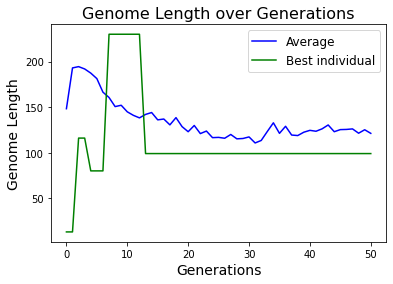

In [69]:
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()